<a href="https://colab.research.google.com/github/chellick/Super_resolution/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
(y_train, _), (y_test, _) = tf.keras.datasets.cifar10.load_data()
y_train = y_train / 255.0

In [ ]:
# y_train = (y_train / 127.5) - 127.5

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(y_train).shuffle(60000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(y_test).shuffle(60000).batch(64)

In [ ]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Input((100, )),
    tf.keras.layers.Dense(2048, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((2, 2, 512)),
    tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh")
    ])

In [ ]:
generator.build
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              204800    
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         3276800   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 256)         1

In [ ]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input((32, 32, 3)),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)

])

In [ ]:
discriminator.build
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4800      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204800    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import time

In [ ]:


@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss_epoch = 0
    for image_batch in dataset:
        gen_loss, disc_loss = train_step(image_batch)
        gen_loss_epoch += tf.keras.backend.mean(gen_loss)



    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start), "Loss: ", gen_loss_epoch)



In [ ]:
train(train_dataset, 30)

Time for epoch 1 is 21.696268558502197 sec Loss:  tf.Tensor(1157.9823, shape=(), dtype=float32)
Time for epoch 2 is 21.078494548797607 sec Loss:  tf.Tensor(1322.0232, shape=(), dtype=float32)
Time for epoch 3 is 21.406579732894897 sec Loss:  tf.Tensor(1737.3562, shape=(), dtype=float32)
Time for epoch 4 is 21.866817474365234 sec Loss:  tf.Tensor(1679.9215, shape=(), dtype=float32)
Time for epoch 5 is 22.196250677108765 sec Loss:  tf.Tensor(1903.7568, shape=(), dtype=float32)
Time for epoch 6 is 22.473020315170288 sec Loss:  tf.Tensor(1963.2051, shape=(), dtype=float32)
Time for epoch 7 is 22.25949764251709 sec Loss:  tf.Tensor(1725.7482, shape=(), dtype=float32)
Time for epoch 8 is 22.110520839691162 sec Loss:  tf.Tensor(1236.7277, shape=(), dtype=float32)
Time for epoch 9 is 22.16724967956543 sec Loss:  tf.Tensor(1155.669, shape=(), dtype=float32)
Time for epoch 10 is 22.30699920654297 sec Loss:  tf.Tensor(1253.908, shape=(), dtype=float32)
Time for epoch 11 is 22.231589317321777 sec 

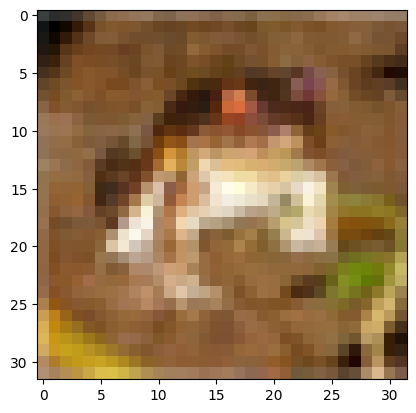

In [ ]:
im = y_train[0]

im
plt.imshow(im)


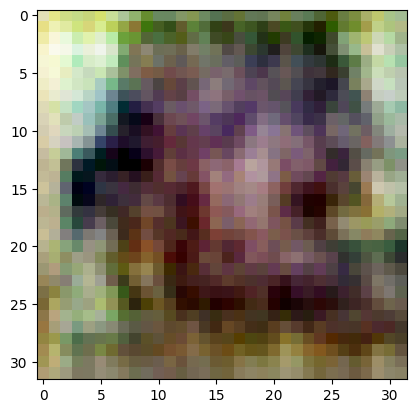

In [ ]:
noise = tf.random.normal([1, 100])
pred = generator(noise)[0]


plt.imshow(pred)